### Inferential Statistics

The Stanford Sentiment Treebank dataset only provides explanatory variables in the form of sentiments associated with words and phrases themselves and the sentence structure that results in the associated sentiment.

Here we examine the relationship between n-gram length and associated Sentiments.

#### N-gram length vs Sentiment Labels Relationship

The original paper highlights this correlation, repeated here for emphasis. The N-grams length is directly related to the height of the node in the tree and is equal to max(left height, right height) + 1 where height of the leaves is assumed to be 1.

In [29]:
# Imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set path to model code
PROJ_ROOT = os.pardir
sys.path.append(PROJ_ROOT)
from src.features.tree import Tree
from src.models.data_manager import DataManager

In [3]:
# Function to get a tuple of (root_ngram, [(ngram, sentiment),...])
label_size = 5
def get_ngram_sentiment(node):
    if node.isLeaf:
        return (1, np.asarray([(1, node.label)]))
    else:
        left_h, left_arr = get_ngram_sentiment(node.left)
        right_h, right_arr = get_ngram_sentiment(node.right)
        curr_h = max(left_h, right_h) + 1
        curr_arr = np.concatenate([[(curr_h, node.label)], left_arr, right_arr])
        return (curr_h, curr_arr)

In [4]:
# Get parsed trees
trees_path = '../src/data/interim/trainDevTestTrees_PTB/trees/'
x_train = DataManager(trees_path).x_train

In [6]:
from collections import Counter, defaultdict
max_x = 0
ngrams = defaultdict(list)
for i in range(len(x_train)):
    h, arr = get_ngram_sentiment(x_train[i].root)
    max_x = max(max_x, h)
    for k, v in arr:
        ngrams[k].append(v)

ngram_counts = defaultdict(Counter)
for k, v in ngrams.items():
    ngram_counts[k] = Counter(v)

# Data
x = range(1, max_x+1)
y = list()
for i in range(max_x):
    a = np.zeros(label_size)
    for j in range(label_size):
        a[j] = ngram_counts[i+1][j]
    y.append(a * 100 / sum(a))

In [31]:
# Save weights for use later
y_clean = np.asarray(y).reshape(-1)
y_clean[y_clean == 0.] = 1.
y_clean = y_clean.reshape(np.asarray(y).shape)
z = np.expand_dims(np.max(y_clean, axis=1), axis=1)*np.ones_like(y_clean) / y_clean
z_t = np.transpose(z)
weights = {'height': x, 'weight_0': z_t[0], 'weight_1': z_t[1], 'weight_2': z_t[2], 'weight_3': z_t[3], 'weight_4': z_t[4]}
dt_weights = pd.DataFrame(data=weights)
dt_weights.to_csv('../src/data/processed/weights.csv')

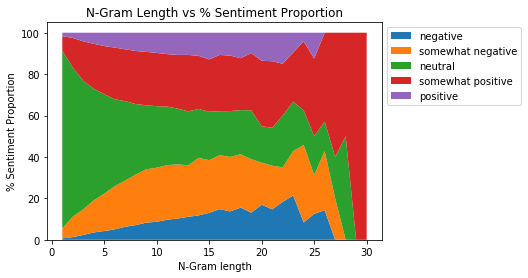

In [32]:
# Plot
_ = plt.stackplot(x, np.transpose(y), labels=['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'])
_ = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
_ = plt.xlabel('N-Gram length')
_ = plt.ylabel('% Sentiment Proportion')
_ = plt.title('N-Gram Length vs % Sentiment Proportion')
plt.show()

The graph reproduced from the original paper shows that the shorter phrases have mostly neutral sentiment and the longer the phrase, the more likely the sentence will have a positive or a negative sentence associated with it. 

We also notice that the sentiment label proportion is skewed depending on height of the node in the parsed tree. The class weights need to be balanced accordingly by height.